# Introduction to Sephora Besterseller Analysis

The following project is an exploration of scraping website data for analysis. The data was taken from the Sephora bestseller's list (https://www.sephora.com/beauty/best-selling-makeup) and then used to understand trends between product qualities and popularity. This analysis is a brief display of the methods used to extract meaning from consumer data and how it can be used to build sales strategies. 

## Setup

In [1]:
import pandas as pd
import requests
import json
from bs4 import BeautifulSoup
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Section I: Retrieving Product Information for Sephora Bestsellers

In [2]:
def do_request(url): #function to provide user agent information to servers
    return requests.get(url, headers ={'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'})

In [3]:
# Get one product to test
r = do_request('https://www.sephora.com/product/P97989778')
soup = BeautifulSoup(r.text)
text = soup.find('script', id = 'linkStore').text
data = json.loads(text)
str(data)[:1000]

{'page': {'product': {'ancillarySkus': [{'biExclusiveLevel': 'none',
     'brandName': 'Rare Beauty by Selena Gomez',
     'image': '/productimages/sku/s2362192-main-Sgrid.jpg',
     'isAppExclusive': False,
     'isBiOnly': False,
     'isExternallySellable': False,
     'isFirstAccess': False,
     'isFree': False,
     'isLimitedEdition': False,
     'isLimitedQuantity': False,
     'isLimitedTimeOffer': False,
     'isNew': False,
     'isOnlineOnly': False,
     'isOnlyFewLeft': False,
     'isOutOfStock': False,
     'isPickUpEligibleSku': True,
     'isReturnable': False,
     'isRopisEligibleSku': True,
     'isSameDayEligibleSku': True,
     'isSephoraExclusive': True,
     'listPrice': '$25.00',
     'maxPurchaseQuantity': 10,
     'productId': 'P38855877',
     'productName': 'Positive Light Liquid Luminizer Highlight',
     'size': '0.5 oz/ 15 mL',
     'skuId': '2362192',
     'skuImages': {'imageUrl': '/productimages/sku/s2362192-main-zoom.jpg'},
     'smallImage': '/prod

In [4]:
def bs_pages(page): #function to return bestseller page contents in an array 
    bs_url = 'https://www.res-x.com/ws/r2/Resonance.aspx?appid=sephora01&tk=429992769294250&sg=1&bx=true&sc=content2_rr&language=ENGLISH&categoryid=cat140006&page=' + str(page)
    bs_text = requests.get(bs_url).text
    bs_json = json.loads('['+ bs_text +']')
    bs_page_data = pd.DataFrame(bs_json)
    return bs_page_data

bs_data = pd.DataFrame()
page = 1
while True: # appends data from every bestseller page until done
    bs_page_data = bs_pages(page)
    if bs_page_data.empty:
        break
    bs_data = bs_data.append(bs_page_data)
    page = page + 1

product_ids = bs_data['id'].tolist()

In [5]:
def get_product_info(product_id): #function to pull product details from product url
    url = 'https://www.sephora.com/product/' + str(product_id)
    r = do_request(url)
    soup = BeautifulSoup(r.text)
    text = soup.find('script', id = 'linkStore').text
    text_to_dict = json.loads(text)
    product_data =  pd.json_normalize(text_to_dict['page']['product'])
    columns = ['productDetails.productId','targetUrl','productDetails.brand.brandId','productDetails.brand.displayName', 'currentSku.listPrice','productDetails.displayName','parentCategory.parentCategory.displayName', 'productDetails.longDescription','currentSku.highlights', 'productDetails.rating','productDetails.reviews']
    product_data = product_data[product_data.columns.intersection(set(columns))]
    for col in columns:
        if col not in product_data.columns:
            product_data[col] = None
            
    product_data = product_data.rename(columns = {'productDetails.productId': 'product_id','targetUrl': 'url','productDetails.brand.brandId': 'brand_id','productDetails.brand.displayName':'brand_name', 'productDetails.displayName':'product_name','parentCategory.parentCategory.displayName':'product_category','currentSku.listPrice':'list_price', 'productDetails.longDescription':'product_description','currentSku.highlights': 'highlighted_descriptors', 'productDetails.rating': 'product_rating','productDetails.reviews':'product_reviews'})

    if product_data['highlighted_descriptors'].isnull().all():
        product_data['highlighted_descriptors'] = [[]]
    product_data['highlighted_descriptors'] = [[highlight['altText'] for highlight in row] for row in product_data.highlighted_descriptors]
    product_data['product_description'] = product_data['product_description'].str.replace(r'<[^<>]*>', '', regex=True)
    product_data['product_description'] = product_data['product_description'].str.replace(r'\n', ' ', regex=True)
    return product_data

# test function:
get_product_info('P97989778')

,url,highlighted_descriptors,list_price,product_category,brand_id,brand_name,product_name,product_description,product_id,product_rating,product_reviews
0,/product/rare-beauty-by-selena-gomez-soft-pinc...,"[Radiant Finish, Liquid Formula, Community Fav...",$23.00,Cheek,6317,Rare Beauty by Selena Gomez,Soft Pinch Liquid Blush,"What it is: A weightless, long-lasting liquid ...",P97989778,4.5308,4429


In [6]:
# Get product details for every product on the bestseller list as a dataframe
from tqdm.auto import tqdm
tqdm.pandas()

bestseller_product_data = pd.DataFrame()
for p_id in tqdm(product_ids, unit="product"):
    product_info = get_product_info(p_id)
    bestseller_product_data = pd.concat([bestseller_product_data, product_info])
    
bestseller_product_data = bestseller_product_data.reset_index(drop=True)
bestseller_product_data

  0%|          | 0/200 [00:00<?, ?product/s]

,url,highlighted_descriptors,list_price,product_category,brand_id,brand_name,product_name,product_description,product_id,product_rating,product_reviews
0,/product/radiant-creamy-concealer-P377873,"[Radiant Finish, Hydrating, Good for: Dark Cir...",$32.00,Face,3976,NARS,Radiant Creamy Concealer,What it is: A multipurpose concealer that brig...,P377873,4.3093,12840
1,/product/rare-beauty-by-selena-gomez-positive-...,"[Light Coverage, Liquid Formula, Shimmer Finis...",$25.00,Face,6317,Rare Beauty by Selena Gomez,Positive Light Liquid Luminizer Highlight,"What it is: A silky, second-skin liquid highli...",P38855877,4.3270,1162
2,/product/multi-peptide-lash-brow-serum-P500423,"[Vegan, Good for: Hair Thinning, Fragrance Fre...",$14.50,Eye,6234,The Ordinary,Multi-Peptide Lash and Brow Serum,"What it is: A concentrated, lightweight serum ...",P500423,4.0053,2255
3,/product/dior-lip-glow-oil-P453814,"[High Shine Finish, Hydrating]",$40.00,Lip,1073,Dior,Lip Glow Oil,"What it is: A nurturing, glossy lip oil that p...",P453814,4.0891,1077
4,/product/make-up-for-ever-hd-skin-matte-velvet...,"[Pressed Powder Formula, Matte Finish, Long-we...",$43.00,Face,4028,MAKE UP FOR EVER,HD Skin Matte Velvet Undetectable Longwear Blu...,"What it is: A lightweight, medium-to-full cove...",P504432,4.4121,165
...,...,...,...,...,...,...,...,...,...,...,...
195,/product/glided-glamour-ac-eyeshadow-palette-w...,"[Long-wearing, Gluten Free, Cruelty-Free]",$54.00,Eye,5648,tarte,Gilded Glamour Amazonian Clay Eyeshadow Wardrobe,What it is: A set of two limited-edition palet...,P501501,4.1290,31
196,/product/sephora-collection-translucent-settin...,"[Vegan, Loose Powder Formula, Natural Finish, ...",$15.00,Face,3902,SEPHORA COLLECTION,Translucent Loose Setting Powder,What it is: A translucent and universal loose ...,P467142,4.0098,102
197,/product/beautiful-skin-radiant-concealer-P500407,"[Radiant Finish, Hyaluronic Acid, Good for: Da...",$33.00,Face,6236,Charlotte Tilbury,Beautiful Skin Medium to Full Coverage Radiant...,"What it is: A creamy, skin-like, medium-to-ful...",P500407,4.0135,444
198,/product/one-size-by-patrick-starrr-mini-on-ti...,"[Best for Oily, Combo, Normal Skin, Without Pa...",$17.00,Makeup,6326,ONE/SIZE by Patrick Starrr,Mini On 'Til Dawn Mattifying Waterproof Settin...,What it is: A waterproof setting spray that gi...,P476718,4.1466,791


# Section II: Analysis of Bestselling Product Data

## Most Popular Product Types on Bestseller List

In [7]:
# Pull all of the unique product categories
product_types = bestseller_product_data['product_category'].unique().tolist()
product_types = pd.Series(product_types)

In [8]:
# Counts how many products are in each category and ranks them by value
bestseller_product_types = pd.DataFrame()
product_frequency = []

for category in product_types:
    frequency = bestseller_product_data['product_category'].value_counts()[str(category)]
    product_frequency.append(frequency)

product_frequency = pd.Series(product_frequency)   
bestseller_product_types_data = {"product_category": product_types, "product_frequency": product_frequency}
bestseller_product_types = pd.concat(bestseller_product_types_data, axis=1).sort_values(by = ['product_frequency'], ascending = False).reset_index(drop=True)
bestseller_product_types.index = np.arange(1, len(bestseller_product_types) + 1)

bestseller_product_types

,product_category,product_frequency
1,Face,77
2,Eye,50
3,Lip,27
4,Cheek,18
5,Makeup,10
6,Brushes & Applicators,7
7,Skincare,4
8,Moisturizers,3
9,Sunscreen,2
10,Mini Size,1


In [9]:
#Sums all categories with less than 8 products together and labels them 'Other'
top_5_types = bestseller_product_types.copy()
top_5_types.loc[top_5_types['product_frequency'] < 8, 'product_category'] = 'Other'
top_5_types = top_5_types.groupby('product_category')['product_frequency'].sum().reset_index().sort_values(by = ['product_frequency'], ascending = False).reset_index(drop = True)

#Organizes categories to a more intuitive order for visualization
other_row = 4
idx = [i for i in range(len(top_5_types)) if i != other_row] + [other_row]
top_5_types = top_5_types.iloc[idx].reset_index(drop=True)
top_5_types.index = np.arange(1, len(top_5_types) + 1)

type_list =bestseller_product_data['product_category']
type_data= pd.DataFrame(type_list).replace(regex=['Brushes & Applicators','Skincare', 'Mini Size', 'Moisturizers', 'Sunscreen', 'Beauty Tools', 'Accessories', 'Cleansers', 'Self Tanners'],value='Other')
type_data['type_tally'] = int(1)

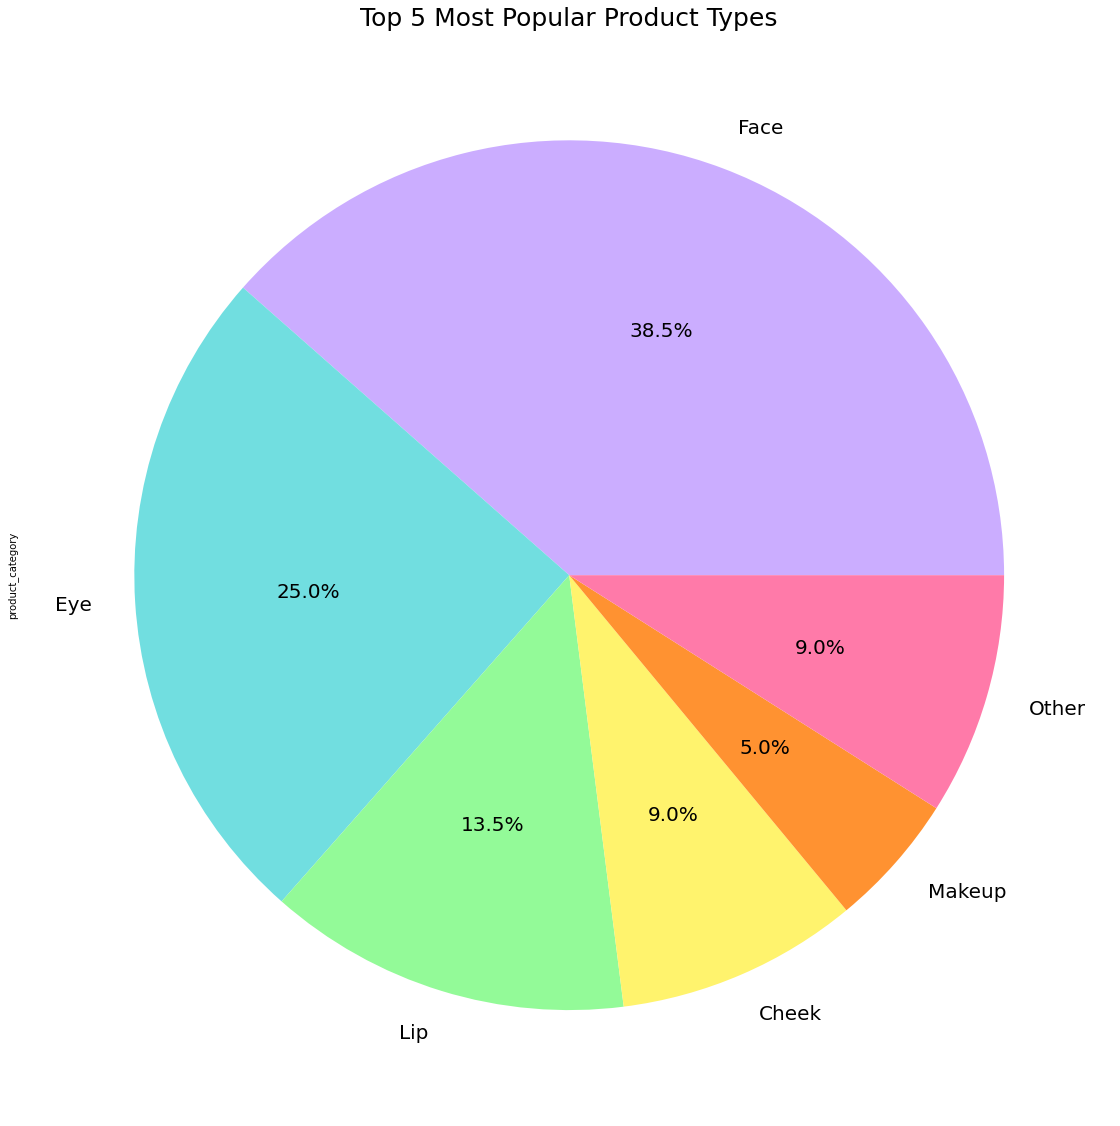

In [10]:
# Creates a pie chart to visualize the distribution of products on the bestseller list in the top categories
colors = ['#CBADFF', '#71DEE0', '#93FA98','#FFF36D','#FF9231','#FF7AA9']
labels = top_5_types['product_category'].tolist()

fig, ax = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax.set_title('Top 5 Most Popular Product Types', fontsize=25, fontname="Times New Roman Bold")
ax = type_data['product_category'].value_counts(normalize=True)
popular_product_types = ax.reindex(labels).plot.pie(autopct='%1.1f%%', colors = colors, textprops={'fontsize': 20})

## Counts of Product Highlights on Bestsellers List

In [11]:
#Pulls product highlights and ratings for each product
highlights_data = bestseller_product_data[['highlighted_descriptors','product_rating']].sort_values(by='product_rating', ascending = False).reset_index(drop=True)
highlights_data

,highlighted_descriptors,product_rating
0,"[Vegan, Cruelty-Free]",4.8974
1,"[Vegan, Best for Dry, Combo, Normal Skin, Crue...",4.8961
2,"[Vegan, Cream Formula, Good for: Dullness/Unev...",4.8924
3,"[Cream Formula, Pressed Powder Formula, Vegan,...",4.8535
4,"[Vegan, Cream Formula, Clean at Sephora, Matte...",4.8173
...,...,...
195,"[Matte Finish, Long-wearing, Without Parabens ]",3.4962
196,"[Natural Finish, Liquid Formula, Hydrating, Lo...",3.4942
197,[],3.4520
198,"[Radiant Finish, Liquid Formula, Clean Plus Pl...",3.4162


In [12]:
def get_product_highlights(data, index_number): # function to return a dataframe with each highlight as a list for each row
    row_list = data.iloc[int(index_number), 0]
    count_highlights = pd.Series(row_list, dtype='object').rename('product_highlights')
    product_highlights = pd.DataFrame(count_highlights)
    return product_highlights

#test function
#get_product_highlights(highlights_data, 1)

In [13]:
highlight_frequency = pd.DataFrame()

for ind in highlights_data.index: # adds new rows to dataframe with product highlights for every product in dataframe
    result = get_product_highlights(highlights_data, ind)
    df_result = pd.DataFrame(result)
    highlight_frequency = pd.concat([highlight_frequency, df_result]).reset_index(drop=True)
    
highlight_frequency = highlight_frequency.value_counts().to_frame().reset_index().rename(columns = {0: 'frequency_count'}) #Sums the product highlights for all products on bestseller list
top_highlights = highlight_frequency[highlight_frequency['frequency_count'] >= 13] # Returns a subset of the data with the 20 most popular product hgihlights
top_highlights.index = np.arange(1, len(top_highlights) + 1)
top_highlights

,product_highlights,frequency_count
1,Vegan,86
2,Long-wearing,74
3,Cruelty-Free,46
4,Natural Finish,45
5,Community Favorite,37
6,Without Parabens,35
7,Matte Finish,34
8,Clean at Sephora,34
9,Liquid Formula,31
10,Hydrating,31


Text(0, 0.5, 'Product Highlight')

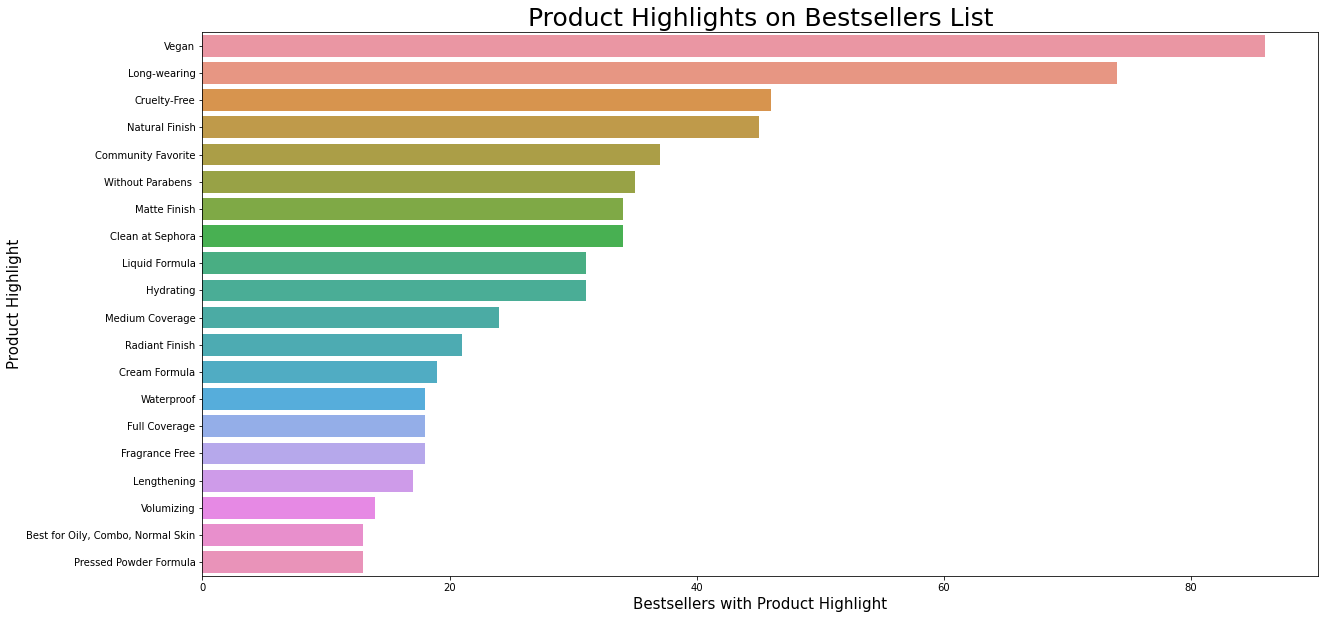

In [14]:
#Creates bar chart to show the distribution of the most popular product highlights on the bestseller list
fig, ax = plt.subplots(figsize=(20, 10))
ph_plot = sns.barplot(data=top_highlights, y='product_highlights', x='frequency_count')
ax.set_title('Product Highlights on Bestsellers List', fontsize=25, fontname="Times New Roman Bold")
ax.set_xlabel('Bestsellers with Product Highlight',fontsize=15)
ax.set_ylabel('Product Highlight',fontsize=15)

## Most Popular Characteristics of Bestselling Products

In [15]:
# Pulls product rating. product id, and product highlights 
rating_highlight_data = bestseller_product_data.copy()
rating_highlight_data = rating_highlight_data[['highlighted_descriptors','product_rating','product_id',]]
rating_highlight_data

,highlighted_descriptors,product_rating,product_id
0,"[Radiant Finish, Hydrating, Good for: Dark Cir...",4.3093,P377873
1,"[Light Coverage, Liquid Formula, Shimmer Finis...",4.3270,P38855877
2,"[Vegan, Good for: Hair Thinning, Fragrance Fre...",4.0053,P500423
3,"[High Shine Finish, Hydrating]",4.0891,P453814
4,"[Pressed Powder Formula, Matte Finish, Long-we...",4.4121,P504432
...,...,...,...
195,"[Long-wearing, Gluten Free, Cruelty-Free]",4.1290,P501501
196,"[Vegan, Loose Powder Formula, Natural Finish, ...",4.0098,P467142
197,"[Radiant Finish, Hyaluronic Acid, Good for: Da...",4.0135,P500407
198,"[Best for Oily, Combo, Normal Skin, Without Pa...",4.1466,P476718


In [16]:
highlights_rating = pd.DataFrame()

for ind in rating_highlight_data.index: # creates a dataframe with product highlights, rating, and number of reviews for each product
    result = get_product_highlights(rating_highlight_data, ind)
    df_result = pd.DataFrame(result)
    df_result['id'] = int(ind)
    
    p_id = rating_highlight_data.iloc[int(ind), 2]
    id_series = pd.Series(p_id).rename('product_id')
    product_id = pd.DataFrame(id_series)
    product_id['id'] = int(ind)
    p_id_highlight = df_result.join(product_id.set_index('id'), on='id')
    
    reviews = bestseller_product_data['product_reviews'].iloc[ind]
    reviews_series = pd.Series(reviews).rename('product_reviews')
    review_counts = pd.DataFrame(reviews_series)
    review_counts['id'] = int(ind)
    highlight_ratings_counts = p_id_highlight.join(review_counts.set_index('id'), on='id')
    highlights_rating = pd.concat([highlights_rating, highlight_ratings_counts]).reset_index(drop=True)

highlights_rating = highlights_rating.merge(rating_highlight_data, on='product_id').drop(columns=['highlighted_descriptors','id','product_id'])

highlights_rating

,product_highlights,product_reviews,product_rating
0,Radiant Finish,12840,4.3093
1,Hydrating,12840,4.3093
2,Good for: Dark Circles,12840,4.3093
3,Long-wearing,12840,4.3093
4,Medium Coverage,12840,4.3093
...,...,...,...
841,Without Parabens,791,4.1466
842,Long-wearing,791,4.1466
843,Waterproof,791,4.1466
844,Vegan,791,4.1466


In [17]:
# Creates a dataframe with the average rating, count, and number of reviews for each product highlight
popular_rating_highlights = highlights_rating.groupby(by='product_highlights').agg(
    avg_rating = ('product_rating','mean'),
    bestseller_count=('product_rating','count'),
    total_ratings = ('product_reviews', 'sum'),
).sort_values(by='total_ratings', ascending=False).reset_index()

conditions = [ #Sets conditions to organize product highlights by popularity
    (popular_rating_highlights['total_ratings'] <= 4953),
    (popular_rating_highlights['total_ratings'] > 4953 ) &  (popular_rating_highlights['total_ratings'] < 13359 ),
    (popular_rating_highlights['total_ratings'] >= 13359) & (popular_rating_highlights['total_ratings'] < 59736),
    (popular_rating_highlights['total_ratings']>= 59736)
    ]
values = ['tier_4', 'tier_3', 'tier_2', 'tier_1']
popular_rating_highlights['tier'] = np.select(conditions, values)

popular_rating_highlights

,product_highlights,avg_rating,bestseller_count,total_ratings,tier
0,Long-wearing,4.264014,74,252424,tier_1
1,Community Favorite,4.227265,37,227681,tier_1
2,Vegan,4.258807,86,194043,tier_1
3,Natural Finish,4.184560,45,112929,tier_1
4,Waterproof,4.271728,18,106277,tier_1
...,...,...,...,...,...
65,Good for: Loss of firmness,4.612100,2,297,tier_4
66,Good for: Anti-Aging,4.612100,2,297,tier_4
67,Strong Hold,4.195100,1,82,tier_4
68,Best for Combination Skin,3.666700,1,42,tier_4


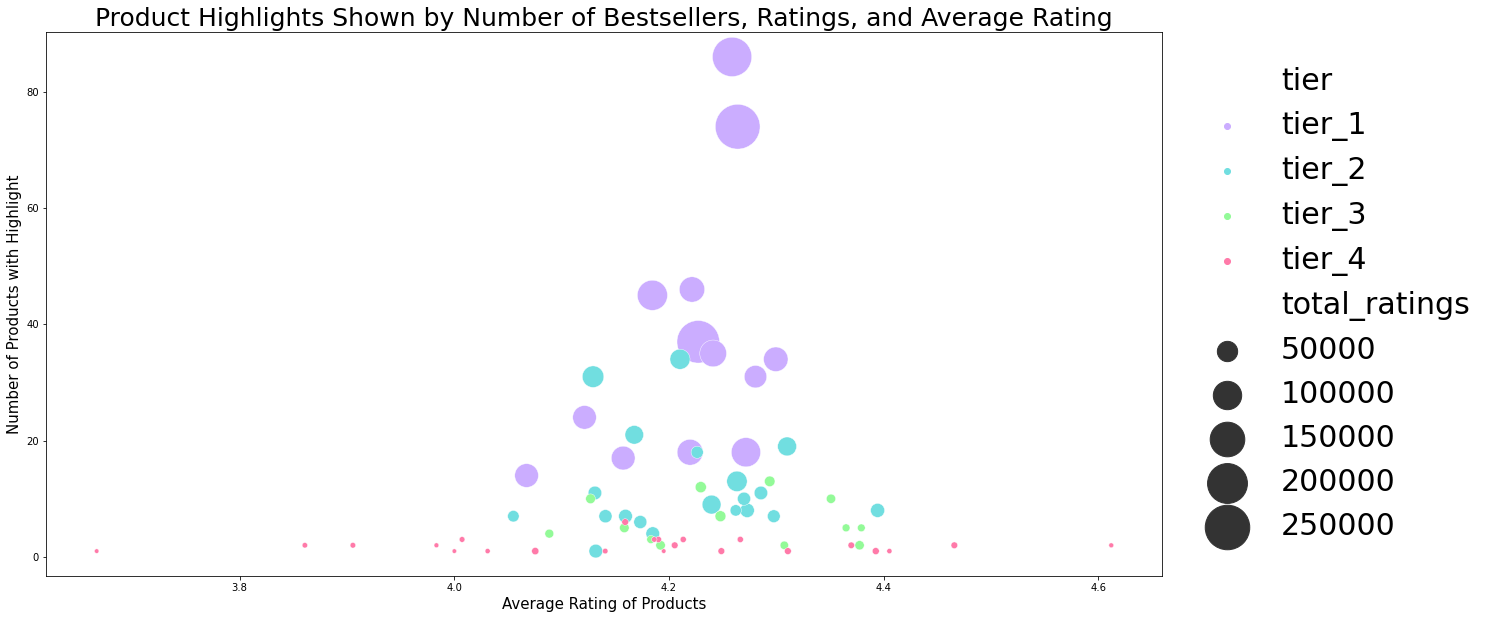

In [18]:
#Bubble chart that comparies product highlights by their popularity in rating and count
fig, ax = plt.subplots(figsize=(20, 10))
bubble_plot = sns.scatterplot(
    data=popular_rating_highlights,
    x="avg_rating",
    size="total_ratings",
    y="bestseller_count",
    hue = 'tier',
    palette = ['#CBADFF', '#71DEE0', '#93FA98','#FF7AA9'],
    legend='brief',
    sizes=(20, 2000),
)

ax.set_title('Product Highlights Shown by Number of Bestsellers, Ratings, and Average Rating', fontsize=25, fontname="Times New Roman Bold")
ax.set_xlabel('Average Rating of Products',fontsize=15)
ax.set_ylabel('Number of Products with Highlight',fontsize=15)


sns.move_legend(
    bubble_plot, "center right",
    bbox_to_anchor=(1.3, 0.5,0,0), ncol=1, title=None, frameon=False,fontsize =30
)